# Ripple-associated CG spectral analysis
https://github.com/Eden-Kramer-Lab/spectral_connectivity/blob/master/examples/Intro_tutorial.ipynb

<br>

### Imports

In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from spectral_connectivity import Multitaper, Connectivity

warnings.filterwarnings('ignore')

<br>

### Define functions

In [2]:
def split_by_phase(df):
    
    sample_df = df.loc[df['phase']=='Sample'].drop(['phase'], axis=1)
    delay_df = df.loc[df['phase']=='Delay'].drop(['phase'], axis=1)
    test_df = df.loc[df['phase']=='Test'].drop(['phase'], axis=1)
    iti_df = df.loc[df['phase']=='ITI'].drop(['phase'], axis=1)
    
    return sample_df, delay_df, test_df, iti_df


def prepare_for_multitaper(df, n_tts):
    '''
    Rearrange and prepare data for multitaper.
    df, Dataframe. 
    n_tts, int - Number of tetrodes (may vary with dataset)
    '''
    
    # Normalise relative timestamp to correct small jitters
    #df['relative_timestamp']=df.relative_timestamp.round(8)

    # Drop unecessary columns
    to_drop = ['start_time', 'end_time','timestamp']#, 'relative_timestamp']
    df = df.drop(to_drop, axis=1)

    # Create TT list
    tts = ['TT{}'.format(x) for x in range(1,n_tts+1)]
    
    # Re-shape dataset into array
    
    reshaped = df.pivot_table(
        index='i',#'relative_timestamp',#"bin_centres", 
        columns="ripple_nr", 
        values=tts,
        dropna=False
    ).values.reshape(
        (
        df['i'].nunique(),
        df['ripple_nr'].nunique(), # number of ripples
        n_tts
        )
    )
    
    return reshaped


def get_conn (df, fs, window, step, exp_type, nblocks):
    
    '''
    Prepares dataframe provided for multitaper
    Creates a multitaper object
    Inputs the multitaper object to create a connectivity object.
    '''
    
    multitaper = Multitaper(
        df, 
        sampling_frequency=fs, 
        n_time_samples_per_window = window,
        n_time_samples_per_step = step,
    )
        
        
    conn = Connectivity.from_multitaper(
        multitaper, 
        expectation_type = exp_type, 
        blocks = nblocks
    )
    
    return conn   

<br>

### Open datasets

In [3]:
main_path = 'PreProcessedData'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

In [4]:
cg_data.loc[(cg_data['phase']=='Test (Pre-choice)')|(cg_data['phase']=='Test (Past-choice)'), 'phase']='Test'

In [5]:
cg_data['i']=cg_data.groupby(['ripple_nr']).cumcount()

<br>

### Split dataset according to sampling rates & phase

In [6]:
# Currently the only session with 20K sampling
# ripple_data.loc[ripple_data.session_code == 20191113131818, 'ripple_nr'].unique() --To check

In [7]:
cg_data_2k = cg_data[cg_data.ripple_nr.between(0,74)]
cg_data_3k = cg_data[~cg_data.ripple_nr.between(0,74)]

In [8]:
cg_data_2k.groupby(['phase']).ripple_nr.nunique(),cg_data_3k.groupby(['phase']).ripple_nr.nunique()

(phase
 Delay     29
 ITI        6
 Sample    14
 Test      26
 Name: ripple_nr, dtype: int64,
 phase
 Delay     114
 ITI        98
 Sample    186
 Test      155
 Name: ripple_nr, dtype: int64)

In [9]:
# Split by phase
sample_2k, delay_2k, test_2k, iti_2k = split_by_phase(cg_data_2k)
sample_3k, delay_3k, test_3k, iti_3k = split_by_phase(cg_data_3k)

<br>

## Create connectivity object

#### 1. Prepare data to create mutitaper:

"If we have three dimensions, dimension 1 is time, dimension 2 is trials, and dimensions 3 is signals. It is important to know note that dimension 2 now has a different meaning in that it represents trials and not signals now. Dimension 3 is now the signals dimension. We will show an example of this later."

time_series : array, shape (n_time_samples, n_trials, n_signals)


#### 2. Create multitaper object

Controls the duration of the segment of time the transformation is computed on (seconds)
w_duration = 0.1

Control how far the time window is slid (overlap).
Setting the step to smaller than the time window duration will make the time windows overlap
step = 0.02

Controls the frequency resolution of the Fourier transformed signal.
Setting this parameter will define the default number of tapers used in the transform 
(number of tapers = 2 * time_halfbandwidth_product - 1.).
Need to study this one although setting the above automatically changes this one
time_halfbandwidth_product = 10


#### 3. Create connectivity object
The Connectivity class computes the frequency-domain connectivity measures from the Fourier coeffcients.

In [179]:
## I NEED TO REPROCESS ALL 30Ks TO HAVE 20Ks - SO THAT ALL SAMPLES HAVE 2K / sec

#### Establish parameters to use

In [10]:
n_tts =14
# Can be over time, trials, tapers or any combination of two or three. Default is by trials and tapers
exp_type = "tapers"
#The time windows used, in seconds 
window_2k=200
window_3k=150
step = 50

#### Prepare data for multitaper

In [221]:
##$ Removed unprocessed tetrodes

test = iti_3k.drop(['TT1', 'TT2', 'TT3', 'TT4', 'TT5','TT6', 'TT7', 'TT8', 'TT9'], axis=1)

In [161]:
#reshaped_iti_3k = prepare_for_multitaper(iti_3k, n_tts)
reshaped = test.pivot_table(
        index='i',#'relative_timestamp',#"bin_centres", 
        columns="ripple_nr", 
        values=['TT10', 'TT11', 'TT12', 'TT13', 'TT14'],
        dropna=False
).values.reshape(
        (
        test['i'].nunique(),
        test['ripple_nr'].nunique(), # number of ripples
        5
        )
)

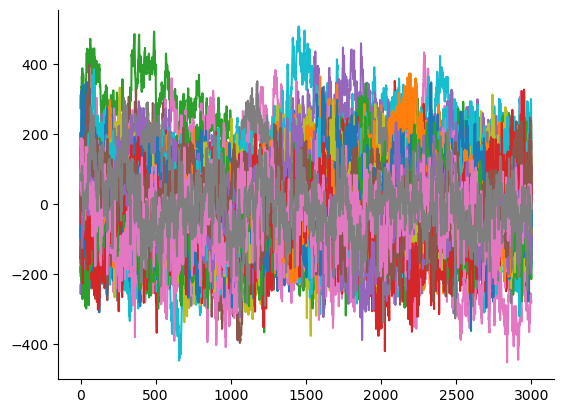

In [189]:
# Plot data for 1 TT after reshaping
plt.plot(reshaped[:,:,0])
sns.despine()

#### Create conn object

In [50]:
# janelas 100 ms
# com overlap de 1/10

In [191]:
iti_3k_conn = get_conn(
    #reshaped_iti_3k, 
    reshaped,
    fs=3000, 
    window=300, 
    step=300, 
    exp_type=exp_type, 
    nblocks=10
)

<br>


### Calculate aggregated power metrics

In [192]:
def get_average_power(conn):
    
    '''
    conn, connectivty object. 
    '''  
    
    # Get time labels
    times = conn.time
    
    # Get frequencies
    freqs = conn.frequencies
    
    # Calculate power ((A,B,C,D) --> A) Time windows; B) trials; C) Frequencies; D) Tetrodes)
    power = iti_3k_conn.power()   
      
    # Average across tetrodes and SWRs
    # Resource: https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html
    averaged_power= np.nanmean(power, axis=(1,3))

    # Get standard deviations across tetrodes and SWRs
    std_power= power.std(axis=(1,3))
    
    return freqs, times,averaged_power, std_power

In [193]:
iti_freqs, iti_times, iti_avg_power, iti_std_power= get_average_power(iti_3k_conn)

<br>

### Power spectral density plot - Heatmap

In [261]:
iti_avg_power

1500

In [262]:
x= np.unique(np.around(iti_avg_power, 2), return_counts=True)[0]
y = np.unique(np.around(iti_avg_power, 2), return_counts=True)[1]

In [264]:
y.size

245

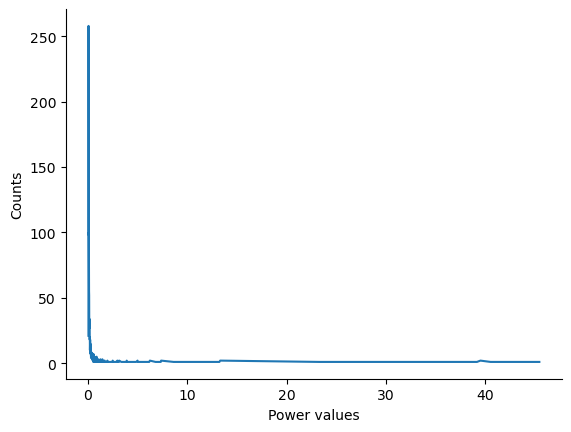

In [263]:
plt.plot(x,y) # seems like I have 
plt.xlabel('Power values')
plt.ylabel('Counts')
sns.despine()

<br>

### Power by bands

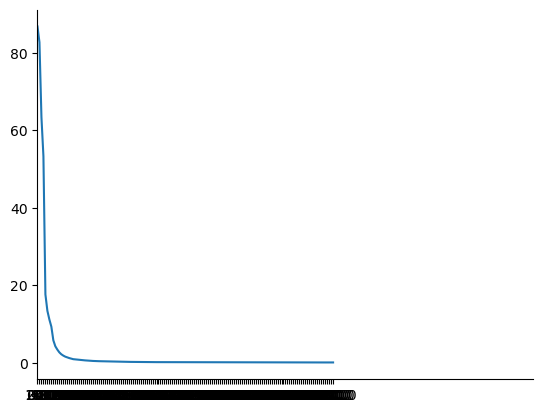

In [134]:
plt.plot(iti_avg_power[0])
plt.xticks(range(0,len(iti_freqs)),  list(iti_freqs))
plt.xlim([0,250])
sns.despine()